In [1]:
import os
import random
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import numpy as np
import hdf5storage
from IPython.core.display import Image, display
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.mplot3d import axes3d
from numpy import ma
import scipy.io as sio
from IPython.display import Image
from matplotlib import cm as CM
import mat73
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers 
from tensorflow.keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.models import Model, load_model

In [2]:
Nb_of_Datasets = 1
Data_Foldername = './CTW2019_Dataset_HDF5_Mat'

Meas_Comb_h =    "%s/h_Estimated_CTW_Train.mat" % (Data_Foldername)
Meas_Comb_r =    "%s/r_Position_CTW_Train.mat" % (Data_Foldername)
Meas_Comb_SNR =   "%s/SNR_CTW_Train.mat" % (Data_Foldername)

# Filename Array
Filenames_h =  [Meas_Comb_h]
Filenames_r =  [Meas_Comb_r]

# Traniningsize 
TrainingsSize = 0.9# 90 %

channel_r=hdf5storage.loadmat(Meas_Comb_r)
channel_h=hdf5storage.loadmat(Meas_Comb_h)
h_estimated=channel_h['h_Estimated']
h_estimated = np.abs(h_estimated)
r_estimated=channel_r['r_Position']
print("shape of h_estimated:",  h_estimated.shape)
print("shape of r_estimated:",  r_estimated.shape)

shape of h_estimated: (17486, 16, 924)
shape of r_estimated: (17486, 3)


In [4]:
nb_epoch =50                           # number of learning epochs
batch_sizes = 256            # size of batches for calculation the gradient

# Number of Antennas 
Nb_Antennas = [2,4,8,16]

# OutputName
#Filename_Pre = '/content/drive/My Drive/Indoor_Positioning_Data/Results/';

# Mean_Error_Train = np.empty([len(Nb_Antennas)])
# Mean_Error_Test = np.empty([len(Nb_Antennas)])
# Schuffle
shuffling_index =random.sample(range(r_estimated[:,0].size),r_estimated[:,0].size);
h_estimated = h_estimated[shuffling_index,:,:]
r_estimated =  r_estimated[shuffling_index,:]
    
# Split Data
h_estimated_train_saved = h_estimated[0:int(TrainingsSize*r_estimated[:,0].size),:,:]
Positions_train =   r_estimated[0:int(TrainingsSize*r_estimated[:,0].size),:]
h_estimated_test_saved =  h_estimated[int(TrainingsSize*r_estimated[:,0].size):,:]
Positions_test =    r_estimated[int(TrainingsSize*r_estimated[:,0].size):,:]
Length_Test = len(Positions_test[:,0])
del h_estimated
print("shape of h_estimated_train:", h_estimated_train_saved.shape)
print("shape of h_estimated_test:",  h_estimated_test_saved.shape)
print("shape of train labels:",  Positions_train.shape)
print("shape of train labels:",  Positions_test.shape)

shape of h_estimated_train: (15737, 16, 924)
shape of h_estimated_test: (1749, 16, 924)
shape of train labels: (15737, 3)
shape of train labels: (1749, 3)


In [5]:
def dist(y_true, y_pred):    
    return tf.reduce_mean((tf.sqrt(tf.square(tf.abs(y_pred[:,0]-y_true[:,0]))+tf.square(tf.abs(y_pred[:,1]-y_true[:,1]))+tf.square(tf.abs(y_pred[:,2]-y_true[:,2])))))

def true_dist(y_true, y_pred):    
    return (np.sqrt(np.square(np.abs(y_pred[:,0]-y_true[:,0]))+np.square(np.abs(y_pred[:,1]-y_true[:,1]))+np.square(np.abs(y_pred[:,2]-y_true[:,2]))))

In [6]:
h_estimated_train_saved=np.reshape(h_estimated_train_saved,(h_estimated_train_saved.shape[0],h_estimated_train_saved.shape[1],h_estimated_train_saved.shape[2],1))
h_estimated_test_saved=np.reshape(h_estimated_test_saved,(h_estimated_test_saved.shape[0],h_estimated_test_saved.shape[1],h_estimated_test_saved.shape[2],1))

print("shape of h_estimated_train:", h_estimated_train_saved.shape)
print("shape of h_estimated_test:",  h_estimated_test_saved.shape)
print("shape of train labels:",  Positions_train.shape)
print("shape of train labels:",  Positions_test.shape)

shape of h_estimated_train: (15737, 16, 924, 1)
shape of h_estimated_test: (1749, 16, 924, 1)
shape of train labels: (15737, 3)
shape of train labels: (1749, 3)


In [8]:
#CNN using only magnitude of h        
nn_input  = Input((16,924,1))
nn_output = Conv2D(32, (3, 3), padding='same', input_shape=(16,924,1), activation='relu')(nn_input)
nn_output = AveragePooling2D(pool_size=(1, 4))(nn_output)
nn_output = Conv2D(32, (3, 3), padding='same', activation='relu')(nn_output)
nn_output = AveragePooling2D(pool_size=(1, 4))(nn_output)
nn_output = Flatten()(nn_output)
nn_output = Dense(256,activation='relu')(nn_output)
nn_output = Dense(256,activation='relu')(nn_output)
nn_output = Dense(256,activation='relu')(nn_output)
nn_output = Dense(3,activation='linear')(nn_output)
cnn = Model(inputs=nn_input,outputs=nn_output)
cnn.compile(optimizer='Adam', loss='mse',metrics=[dist])
cnn.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 16, 924, 1)]      0         
_________________________________________________________________
conv2d (Conv2D)              (None, 16, 924, 32)       320       
_________________________________________________________________
average_pooling2d (AveragePo (None, 16, 231, 32)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 231, 32)       9248      
_________________________________________________________________
average_pooling2d_1 (Average (None, 16, 57, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 29184)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               747136

In [10]:
# Train Neural Network
# for b in batch_sizes:
b=256
train_hist = cnn.fit(x=h_estimated_train_saved,y=Positions_train,batch_size=b,epochs=nb_epoch,validation_data=(h_estimated_test_saved, Positions_test))

#save weights
cnn.save_weights('CNN1_magnitude_h_16_Antennas.h5')
# Evaluate Performance
r_Positions_pred_train = cnn.predict(h_estimated_train_saved)
r_Positions_pred_test = cnn.predict(h_estimated_test_saved)
errors_train = true_dist(Positions_train,r_Positions_pred_train)
errors_test  = true_dist(Positions_test,r_Positions_pred_test)

Mean_Error_Train =  np.mean(np.abs(errors_train))
Mean_Error_Test = np.mean(np.abs(errors_test))
print("Mean error on Train area:",Mean_Error_Train)
print("Mean error on Test  area:",Mean_Error_Test)

Train on 15737 samples, validate on 1749 samples
Epoch 1/50
15737/15737 [==============================] - 101s 6ms/sample - loss: 0.8923 - dist: 1.3389 - val_loss: 0.3921 - val_dist: 0.9619
Epoch 2/50
15737/15737 [==============================] - 73s 5ms/sample - loss: 0.3350 - dist: 0.8706 - val_loss: 0.3310 - val_dist: 0.8503
Epoch 3/50
15737/15737 [==============================] - 72s 5ms/sample - loss: 0.2969 - dist: 0.8151 - val_loss: 0.2787 - val_dist: 0.7890
Epoch 4/50
15737/15737 [==============================] - 73s 5ms/sample - loss: 0.2794 - dist: 0.7869 - val_loss: 0.2711 - val_dist: 0.7694
Epoch 5/50
15737/15737 [==============================] - 72s 5ms/sample - loss: 0.2706 - dist: 0.7705 - val_loss: 0.2481 - val_dist: 0.7408
Epoch 6/50
15737/15737 [==============================] - 72s 5ms/sample - loss: 0.2491 - dist: 0.7355 - val_loss: 0.2286 - val_dist: 0.7079
Epoch 7/50
15737/15737 [==============================] - 72s 5ms/sample - loss: 0.2362 - dist: 0.7109 -

In [11]:
b=256
train_hist = cnn.fit(x=h_estimated_train_saved,y=Positions_train,batch_size=b,epochs=nb_epoch,validation_data=(h_estimated_test_saved, Positions_test))

#save weights
cnn.save_weights('CNN1_magnitude_h_16_Antennas.h5')
# Evaluate Performance
r_Positions_pred_train = cnn.predict(h_estimated_train_saved)
r_Positions_pred_test = cnn.predict(h_estimated_test_saved)
errors_train = true_dist(Positions_train,r_Positions_pred_train)
errors_test  = true_dist(Positions_test,r_Positions_pred_test)

Mean_Error_Train =  np.mean(np.abs(errors_train))
Mean_Error_Test = np.mean(np.abs(errors_test))
print("Mean error on Train area:",Mean_Error_Train)
print("Mean error on Test  area:",Mean_Error_Test)

Train on 15737 samples, validate on 1749 samples
Epoch 1/50
15737/15737 [==============================] - 146s 9ms/sample - loss: 0.0060 - dist: 0.1147 - val_loss: 0.0227 - val_dist: 0.1899
Epoch 2/50
15737/15737 [==============================] - 79s 5ms/sample - loss: 0.0060 - dist: 0.1154 - val_loss: 0.0236 - val_dist: 0.1976
Epoch 3/50
15737/15737 [==============================] - 74s 5ms/sample - loss: 0.0061 - dist: 0.1162 - val_loss: 0.0244 - val_dist: 0.2070
Epoch 4/50
15737/15737 [==============================] - 73s 5ms/sample - loss: 0.0058 - dist: 0.1137 - val_loss: 0.0232 - val_dist: 0.1938
Epoch 5/50
15737/15737 [==============================] - 72s 5ms/sample - loss: 0.0062 - dist: 0.1181 - val_loss: 0.0234 - val_dist: 0.1936
Epoch 6/50
15737/15737 [==============================] - 72s 5ms/sample - loss: 0.0050 - dist: 0.1048 - val_loss: 0.0230 - val_dist: 0.1918
Epoch 7/50
15737/15737 [==============================] - 72s 5ms/sample - loss: 0.0049 - dist: 0.1050 -

In [14]:
b=256
train_hist = cnn.fit(x=h_estimated_train_saved,y=Positions_train,batch_size=b,epochs=nb_epoch,validation_data=(h_estimated_test_saved, Positions_test))

#save weights
cnn.save_weights('CNN1_magnitude_h_16_Antennas.h5')
# Evaluate Performance
r_Positions_pred_train = cnn.predict(h_estimated_train_saved)
r_Positions_pred_test = cnn.predict(h_estimated_test_saved)
errors_train = true_dist(Positions_train,r_Positions_pred_train)
errors_test  = true_dist(Positions_test,r_Positions_pred_test)

Mean_Error_Train =  np.mean(np.abs(errors_train))
Mean_Error_Test = np.mean(np.abs(errors_test))
print("Mean error on Train area:",Mean_Error_Train)
print("Mean error on Test  area:",Mean_Error_Test)

Train on 15737 samples, validate on 1749 samples
Epoch 1/50
15737/15737 [==============================] - 73s 5ms/sample - loss: 0.0036 - dist: 0.0898 - val_loss: 0.0184 - val_dist: 0.1642
Epoch 2/50
15737/15737 [==============================] - 72s 5ms/sample - loss: 0.0020 - dist: 0.0669 - val_loss: 0.0172 - val_dist: 0.1524
Epoch 3/50
15737/15737 [==============================] - 73s 5ms/sample - loss: 0.0018 - dist: 0.0631 - val_loss: 0.0174 - val_dist: 0.1552
Epoch 4/50
15737/15737 [==============================] - 73s 5ms/sample - loss: 0.0021 - dist: 0.0686 - val_loss: 0.0178 - val_dist: 0.1596
Epoch 5/50
15737/15737 [==============================] - 72s 5ms/sample - loss: 0.0025 - dist: 0.0759 - val_loss: 0.0189 - val_dist: 0.1687
Epoch 6/50
15737/15737 [==============================] - 72s 5ms/sample - loss: 0.0027 - dist: 0.0774 - val_loss: 0.0172 - val_dist: 0.1528
Epoch 7/50
15737/15737 [==============================] - 72s 5ms/sample - loss: 0.0019 - dist: 0.0657 - 

Text(0.5,0,'Distance error')

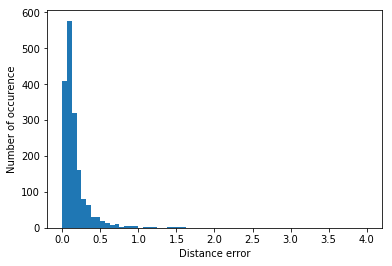

In [15]:
# Histogramm of errors on test Area
errors = true_dist(r_Positions_pred_test , Positions_test)
plt.hist(errors,bins=64,range=(0,4))
plt.ylabel('Number of occurence')
plt.xlabel('Distance error')

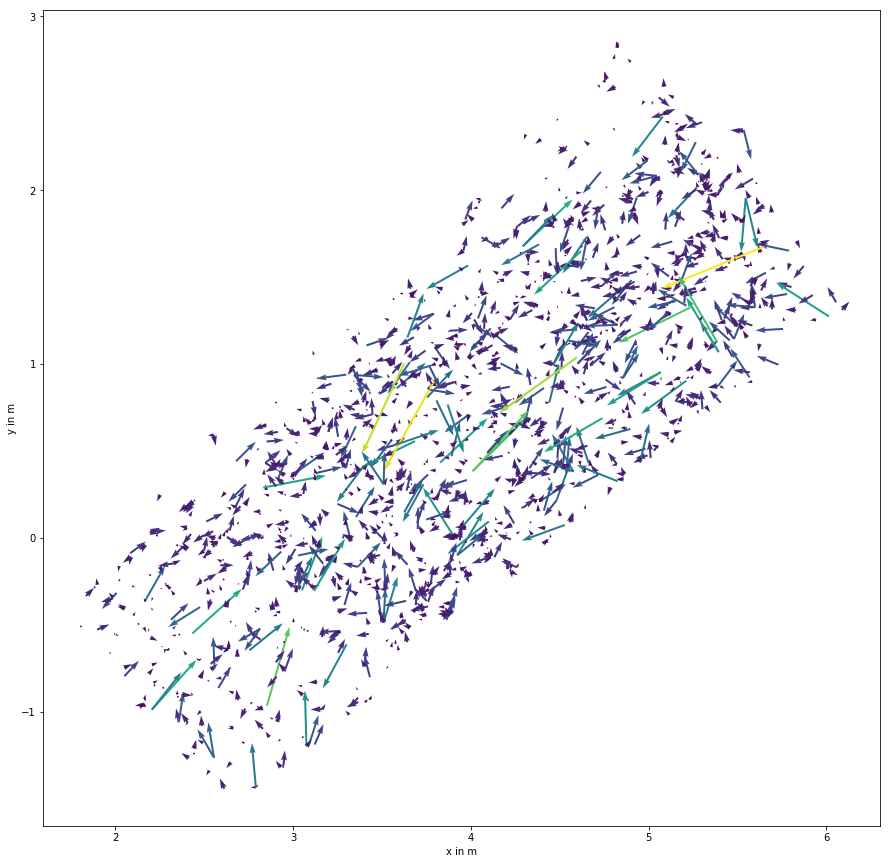

In [16]:
# Error Vector over Area in XY
error_vectors = np.real(r_Positions_pred_test - Positions_test)
plt.figure(figsize=(15,15))
plt.quiver(np.real(Positions_test[:,0]),np.real(Positions_test[:,1]),error_vectors[:,0],error_vectors[:,1],errors)
plt.xlabel("x in m")
plt.ylabel("y in m")
plt.show()

In [17]:
np.mean(errors)

0.1609874967857168

In [19]:
import pickle
with open('CNN1_magnitude_h_16_Antenna_Mean_TestError', 'wb') as f:
    pickle.dump([errors], f)

In [22]:
#CNN using onli magnitude of h    
from tensorflow.keras.layers import Dropout, BatchNormalization

nn_input  = Input((16,924,1))



drop_rate=0.3
nn_input  = Input((16,924,1))
nn_output = Conv2D(16, (3, 3), padding='same', input_shape=(16,924,1))(nn_input)
#nn_output = BatchNormalization()(nn_output)
nn_output = Activation('relu')(nn_output)
nn_output = AveragePooling2D(pool_size=(1, 8))(nn_output)
nn_output = Conv2D(16, (3, 3), padding='same')(nn_output)
#nn_output = BatchNormalization()(nn_output)
nn_output = Activation('relu')(nn_output)
nn_output = AveragePooling2D(pool_size=(1, 4))(nn_output)
nn_output = Conv2D(8, (3, 3), padding='same')(nn_output)
#nn_output = BatchNormalization()(nn_output)
nn_output = Activation('relu')(nn_output)
nn_output = AveragePooling2D(pool_size=(1, 2))(nn_output)
nn_output = Flatten()(nn_output)
nn_output = Dense(256,activation='relu')(nn_output)
nn_output = Dropout(drop_rate)(nn_output)
nn_output = Dense(256,activation='relu')(nn_output)
nn_output = Dropout(drop_rate)(nn_output)
nn_output = Dense(128,activation='relu')(nn_output)
nn_output = Dropout(drop_rate)(nn_output)
nn_output = Dense(3,activation='linear')(nn_output)
cnn2 = Model(inputs=nn_input,outputs=nn_output)
cnn2.compile(optimizer='Adam', loss='mse',metrics=[dist])
cnn2.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 16, 924, 1)]      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 16, 924, 16)       160       
_________________________________________________________________
activation_3 (Activation)    (None, 16, 924, 16)       0         
_________________________________________________________________
average_pooling2d_5 (Average (None, 16, 115, 16)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 16, 115, 16)       2320      
_________________________________________________________________
activation_4 (Activation)    (None, 16, 115, 16)       0         
_________________________________________________________________
average_pooling2d_6 (Average (None, 16, 28, 16)        0   

In [25]:
# for b in batch_sizes:
b=256
train_hist = cnn2.fit(x=h_estimated_train_saved,y=Positions_train,batch_size=b,epochs=nb_epoch,validation_data=(h_estimated_test_saved, Positions_test))

#save weights
cnn2.save_weights('CNN2_magnitude_h_16_Antennas.h5')
# Evaluate Performance
r_Positions_pred_train = cnn2.predict(h_estimated_train_saved)
r_Positions_pred_test = cnn2.predict(h_estimated_test_saved)
errors_train = true_dist(Positions_train,r_Positions_pred_train)
errors_test  = true_dist(Positions_test,r_Positions_pred_test)

Mean_Error_Train =  np.mean(np.abs(errors_train))
Mean_Error_Test = np.mean(np.abs(errors_test))
print("Mean error on Train area:",Mean_Error_Train)
print("Mean error on Test  area:",Mean_Error_Test)

Train on 15737 samples, validate on 1749 samples
Epoch 1/50
15737/15737 [==============================] - 33s 2ms/sample - loss: 0.0556 - dist: 0.3473 - val_loss: 0.0397 - val_dist: 0.2787
Epoch 2/50
15737/15737 [==============================] - 32s 2ms/sample - loss: 0.0546 - dist: 0.3452 - val_loss: 0.0328 - val_dist: 0.2483
Epoch 3/50
15737/15737 [==============================] - 33s 2ms/sample - loss: 0.0543 - dist: 0.3431 - val_loss: 0.0329 - val_dist: 0.2532
Epoch 4/50
15737/15737 [==============================] - 33s 2ms/sample - loss: 0.0517 - dist: 0.3352 - val_loss: 0.0378 - val_dist: 0.2640
Epoch 5/50
15737/15737 [==============================] - 33s 2ms/sample - loss: 0.0520 - dist: 0.3353 - val_loss: 0.0346 - val_dist: 0.2597
Epoch 6/50
15737/15737 [==============================] - 33s 2ms/sample - loss: 0.0519 - dist: 0.3362 - val_loss: 0.0358 - val_dist: 0.2639
Epoch 7/50
15737/15737 [==============================] - 33s 2ms/sample - loss: 0.0514 - dist: 0.3331 - 

In [26]:
# for b in batch_sizes:
b=256
train_hist = cnn2.fit(x=h_estimated_train_saved,y=Positions_train,batch_size=b,epochs=nb_epoch,validation_data=(h_estimated_test_saved, Positions_test))

#save weights
cnn2.save_weights('CNN2_magnitude_h_16_Antennas.h5')
# Evaluate Performance
r_Positions_pred_train = cnn2.predict(h_estimated_train_saved)
r_Positions_pred_test = cnn2.predict(h_estimated_test_saved)
errors_train = true_dist(Positions_train,r_Positions_pred_train)
errors_test  = true_dist(Positions_test,r_Positions_pred_test)

Mean_Error_Train =  np.mean(np.abs(errors_train))
Mean_Error_Test = np.mean(np.abs(errors_test))
print("Mean error on Train area:",Mean_Error_Train)
print("Mean error on Test  area:",Mean_Error_Test)

Train on 15737 samples, validate on 1749 samples
Epoch 1/50
15737/15737 [==============================] - 35s 2ms/sample - loss: 0.0387 - dist: 0.2861 - val_loss: 0.0336 - val_dist: 0.2485
Epoch 2/50
15737/15737 [==============================] - 35s 2ms/sample - loss: 0.0387 - dist: 0.2870 - val_loss: 0.0304 - val_dist: 0.2381
Epoch 3/50
15737/15737 [==============================] - 34s 2ms/sample - loss: 0.0361 - dist: 0.2787 - val_loss: 0.0285 - val_dist: 0.2294
Epoch 4/50
15737/15737 [==============================] - 33s 2ms/sample - loss: 0.0385 - dist: 0.2847 - val_loss: 0.0320 - val_dist: 0.2297
Epoch 5/50
15737/15737 [==============================] - 33s 2ms/sample - loss: 0.0385 - dist: 0.2855 - val_loss: 0.0313 - val_dist: 0.2409
Epoch 6/50
15737/15737 [==============================] - 33s 2ms/sample - loss: 0.0367 - dist: 0.2783 - val_loss: 0.0265 - val_dist: 0.2163
Epoch 7/50
15737/15737 [==============================] - 33s 2ms/sample - loss: 0.0382 - dist: 0.2838 - 

Text(0.5,0,'Distance error')

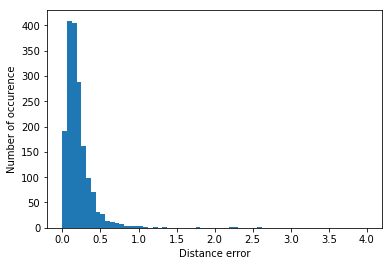

In [27]:
# Histogramm of errors on test Area
errors = true_dist(r_Positions_pred_test , Positions_test)
plt.hist(errors,bins=64,range=(0,4))
plt.ylabel('Number of occurence')
plt.xlabel('Distance error')

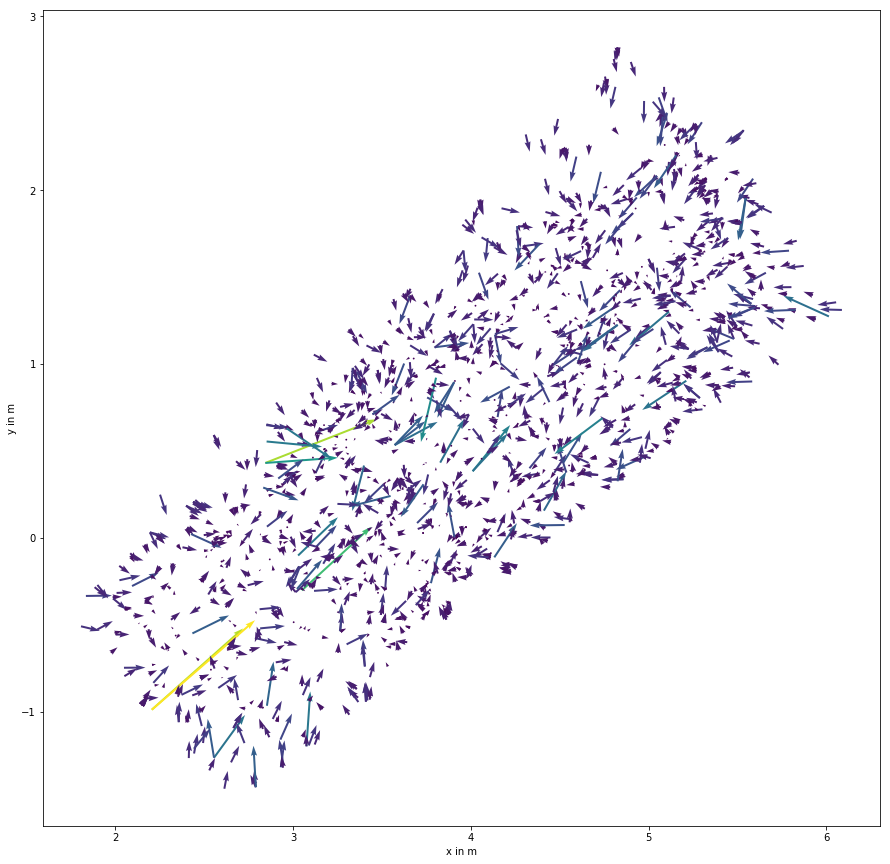

In [28]:
# Error Vector over Area in XY
error_vectors = np.real(r_Positions_pred_test - Positions_test)
plt.figure(figsize=(15,15))
plt.quiver(np.real(Positions_test[:,0]),np.real(Positions_test[:,1]),error_vectors[:,0],error_vectors[:,1],errors)
plt.xlabel("x in m")
plt.ylabel("y in m")
plt.show()

In [29]:
import pickle
with open('CNN2_magnitude_h_16_Antenna_Mean_TestError', 'wb') as f:
    pickle.dump([errors], f)